In [1]:
# importing Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# reading in the data frame from EDA notebook
df = pd.read_csv("data/cleaned-data.csv")
df.head()



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,target
0,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,1
1,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,1
2,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,0
3,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,0
4,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,1


In [2]:
# importing necessary functions from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
baseline_logreg = LogisticRegression(fit_intercept = False, solver = "liblinear", random_state = 42)
# baseline KNN
baseline_knn = KNeighborsClassifier()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# target variable
y = df["target"]
# predictors
X = df.drop("target", axis = 1)
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



# Since KNN is a distance-based classifier, if data is in different scales, 
# then larger scaled features have a larger impact on the distance between points.
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)
scaled_df_train = pd.DataFrame(scaled_data_train, columns = X.columns)
scaled_df_test = pd.DataFrame(scaled_data_test, columns = X.columns)

In [4]:
from Code.simulations import simulate
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

acc_scores = []
f1_scores = []
roc_scores = {}
auc_scores = {}

# name of algorithm, classifier instance
baseline_algs = [("Logistic\nRegression", baseline_logreg), 
                 ("KNN", baseline_knn)]

# train each model, store results
for name, clf in baseline_algs:
    if name != "KNN":
        results, roc = simulate(clf, X_train, X_test, y_train, y_test, True)
        # STORE ACCURACY
        acc_scores.append([name, results[0], "Baseline Train"])
        acc_scores.append([name, results[1], "Baseline Test"])
        # # STORE F1 SCORE
        f1_scores.append([name, results[2], "Baseline Train"])
        f1_scores.append([name, results[3], "Baseline Test"])
        # STORE ROC and AUC
        roc_scores[name] = roc
        auc_scores[name] = results[4]
    else:
        results, roc = simulate(clf, scaled_df_train, scaled_df_test, 
                                y_train, y_test, True)
        # STORE ACCURACY
        acc_scores.append([name, results[0], "Baseline Train"])
        acc_scores.append([name, results[1], "Baseline Test"])
        # # STORE F1 SCORE
        f1_scores.append([name, results[2], "Baseline Train"])
        f1_scores.append([name, results[3], "Baseline Test"])
        # STORE ROC and AUC
        roc_scores[name] = roc
        auc_scores[name] = results[4]

Text(0, 0.5, 'Area Under the Curve')

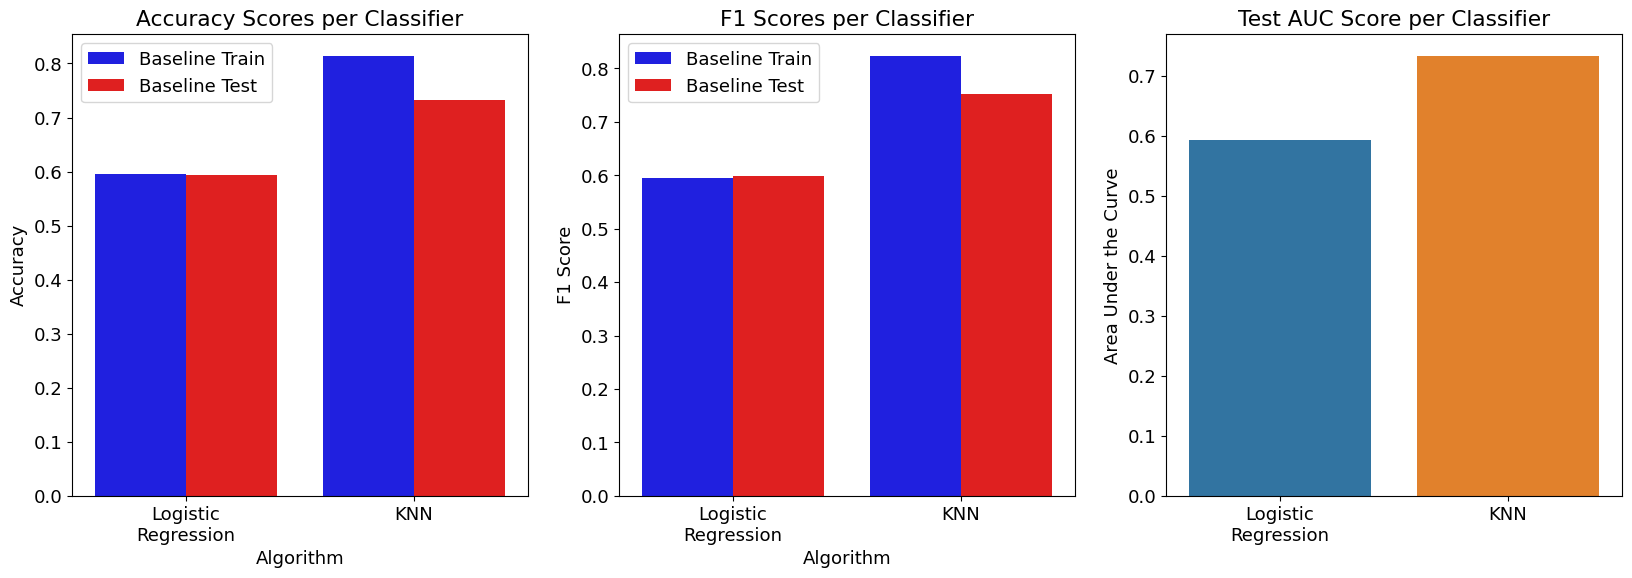

In [5]:
# creating data frames of the results obtained
df_baseline_acc = pd.DataFrame(acc_scores, columns = ["Algorithm", "Accuracy", "Type"])
df_baseline_acc.head()
df_baseline_f1 = pd.DataFrame(f1_scores, columns = ["Algorithm", "F1 Score", "Type"])
df_baseline_auc = pd.DataFrame(auc_scores, index = [0])

plt.rcParams["font.size"] = 13

fig, ax = plt.subplots(1,3, figsize = (20,6))
sns.barplot(x = "Algorithm", y = "Accuracy", hue = "Type", data = df_baseline_acc, palette = ["b", "r"], ax = ax[0])
ax[0].set_title("Accuracy Scores per Classifier")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc = "upper left")

sns.barplot(x = "Algorithm", y = "F1 Score", hue = "Type",
           data = df_baseline_f1, palette = ["b", "r"], ax = ax[1])
ax[1].set_title("F1 Scores per Classifier")
ax[1].set_ylabel("F1 Score")
ax[1].legend(loc = "upper left")

sns.barplot(x = df_baseline_auc.columns, y = df_baseline_auc.iloc[0], ax = ax[2])
ax[2].set_title("Test AUC Score per Classifier")
ax[2].set_ylabel("Area Under the Curve")

{'Logistic\nRegression': [array([0.        , 0.41971877, 1.        ]), array([0.        , 0.60623974, 1.        ])], 'KNN': [array([0.        , 0.34450621, 1.        ]), array([0.        , 0.81083744, 1.        ])]}


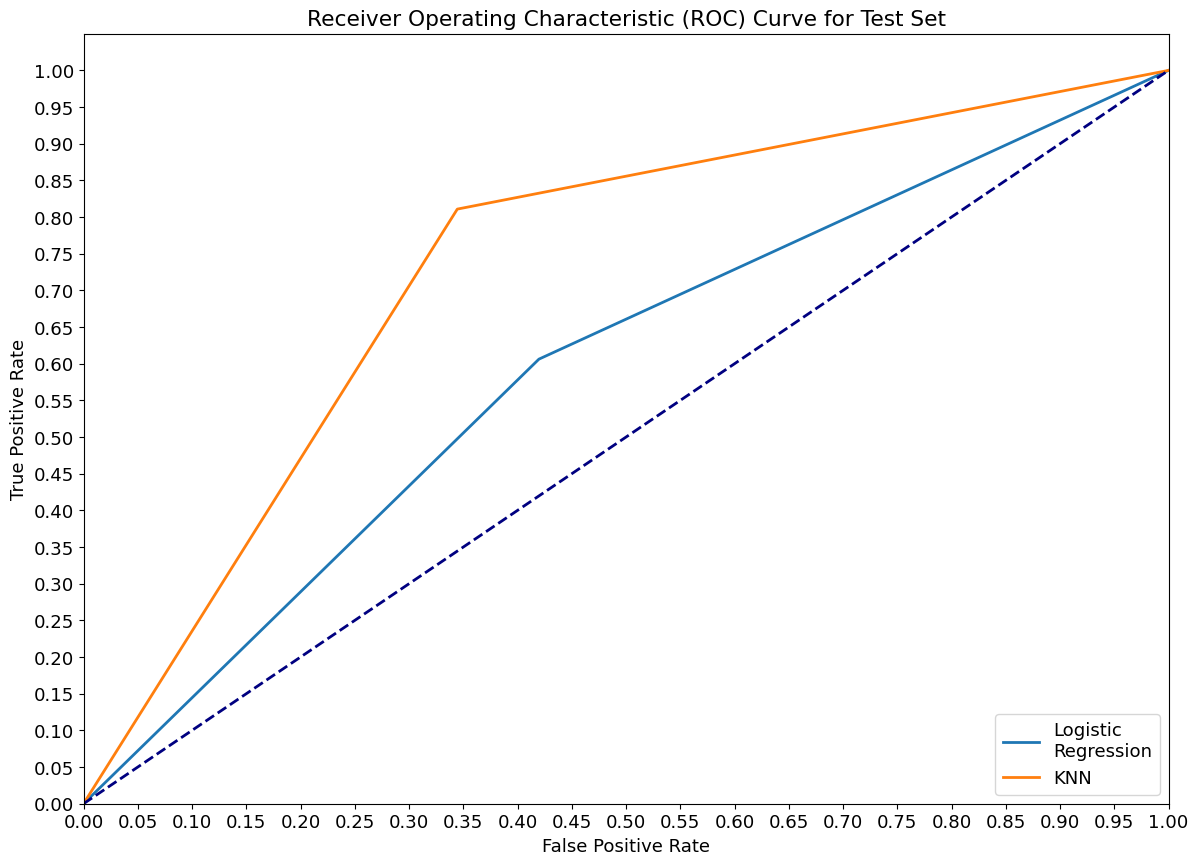

In [6]:
from Code import performance as pfm

plt.figure(figsize = (14,10))
print(roc_scores)
pfm.plot_roc(roc_scores)

Optimising the Logistic Regression Classifier

In [7]:

# target
y = df["target"]
# predictors (cleaned)
X = df.drop("target", axis = 1)
# 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [8]:
from sklearn.feature_selection import RFECV

rfe = RFECV(LogisticRegression(fit_intercept = False, C = 1e12, solver = "liblinear", 
                               random_state = 42), cv = 5)
X_rfe_train = rfe.fit_transform(X_train, y_train)
X_rfe_test = rfe.transform(X_test)

print("The optimal number of features is: ", rfe.n_features_)
print("\n")
print("The chosen features are:", list(X.columns[rfe.support_]))

The optimal number of features is:  13


The chosen features are: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'chorus_hit']


In [9]:
import statsmodels.api as sm

df_rfe_train = pd.DataFrame(X_rfe_train, columns = X.columns[rfe.support_])

log_rfe_model = sm.Logit(list(y_train), df_rfe_train).fit()

log_rfe_model.summary()

Optimization terminated successfully.
         Current function value: 0.528164
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28480
Model:                          Logit   Df Residuals:                    28467
Method:                           MLE   Df Model:                           12
Date:                Sun, 26 Feb 2023   Pseudo R-squ.:                  0.2379
Time:                        17:07:04   Log-Likelihood:                -15042.
converged:                       True   LL-Null:                       -19738.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
danceability         3.3570      0.106     31.708      0.000       3.150       3.565
energy              -1.9229      0.107    -17.945      0.000      -2.133      -1.713
key                  0.0083      0.004      2.085      0.037       0.001       0.016
loudness             0.1089      0.005     22.912      0.000       0.100       0.118
mode                 0.4015      0.031     12.939      0.000       0.341       0.462
speechiness         -3.2730      0.187    -17.464      0.000      -3.640      -2.906
acousticness        -1.3169      0.058    -22.621      0.000      -1.431      -1.203
instrumentalness    -3.3571      0.080    -41.838      0.000      -3.514      -3.200
liveness            -0.1841      0.083     -2.226      0.026      -0.346      -0.022
valence              0.4255      0.069      6.127      0.000       0.289       0.562
tempo                0.0025      0.000      5.335      0.000       0.002       0.003
time_signature       0.1572      0.028      5.533      0.000       0.102       0.213
chorus_hit          -0.0009      0.001     -1.199      0.230      -0.002       0.001
====================================================================================
"""

In [10]:
# range of possible C values
C = np.linspace(1, 10000)
# store train/test scores
acc_train_scores = []
acc_test_scores = []
f1_train_scores = []
f1_test_scores = []
auc_scores = []

for c in C:
    lr = LogisticRegression(C = c, fit_intercept = False, random_state = 42,
                           solver = "liblinear")
    results = simulate(lr, X_rfe_train, X_rfe_test, y_train, y_test)
    
    acc_train_scores.append(results[0])
    acc_test_scores.append(results[1])
    f1_train_scores.append(results[2])
    f1_test_scores.append(results[3])
    auc_scores.append(results[4])

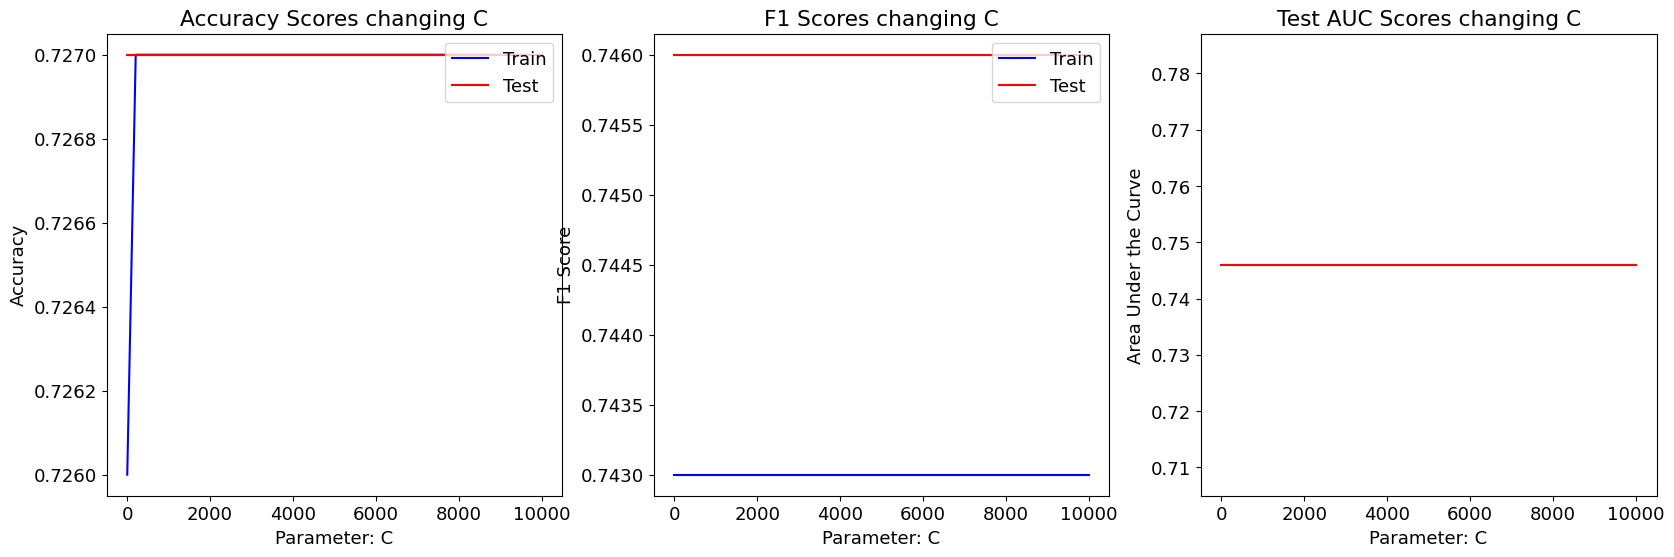

In [11]:
stats = [acc_train_scores, acc_test_scores, f1_train_scores, f1_test_scores, auc_scores]

fig, ax = plt.subplots(1,3, figsize = (20,6))

pfm.perform_visualisation(C, stats, ax, "C")

In [12]:
#Final Logistic Regression Model
final_log = LogisticRegression(fit_intercept = False, C = 1e12, solver = "liblinear", random_state = 42)
log_stats, log_roc = simulate(final_log, X_rfe_train, X_rfe_test, y_train, y_test, roc = True)



Optimising the KNN classifier

In [13]:
# target
y = df["target"]
# predictors (cleaned)
X = df.drop("target", axis = 1)
# 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [14]:
# scale data since we're working with KNN
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)
scaled_df_train = pd.DataFrame(scaled_data_train, columns = X_train.columns)
scaled_df_test = pd.DataFrame(scaled_data_test, columns = X_test.columns)

In [15]:
# range of possible k values
K = np.arange(1, 26, 2)
# store train/test scores
acc_train_scores = []
acc_test_scores = []
f1_train_scores = []
f1_test_scores = []
auc_scores = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors = k)
    results = simulate(knn, scaled_df_train, scaled_df_test, y_train, y_test)
    
    acc_train_scores.append(results[0])
    acc_test_scores.append(results[1])
    f1_train_scores.append(results[2])
    f1_test_scores.append(results[3])
    auc_scores.append(results[4])

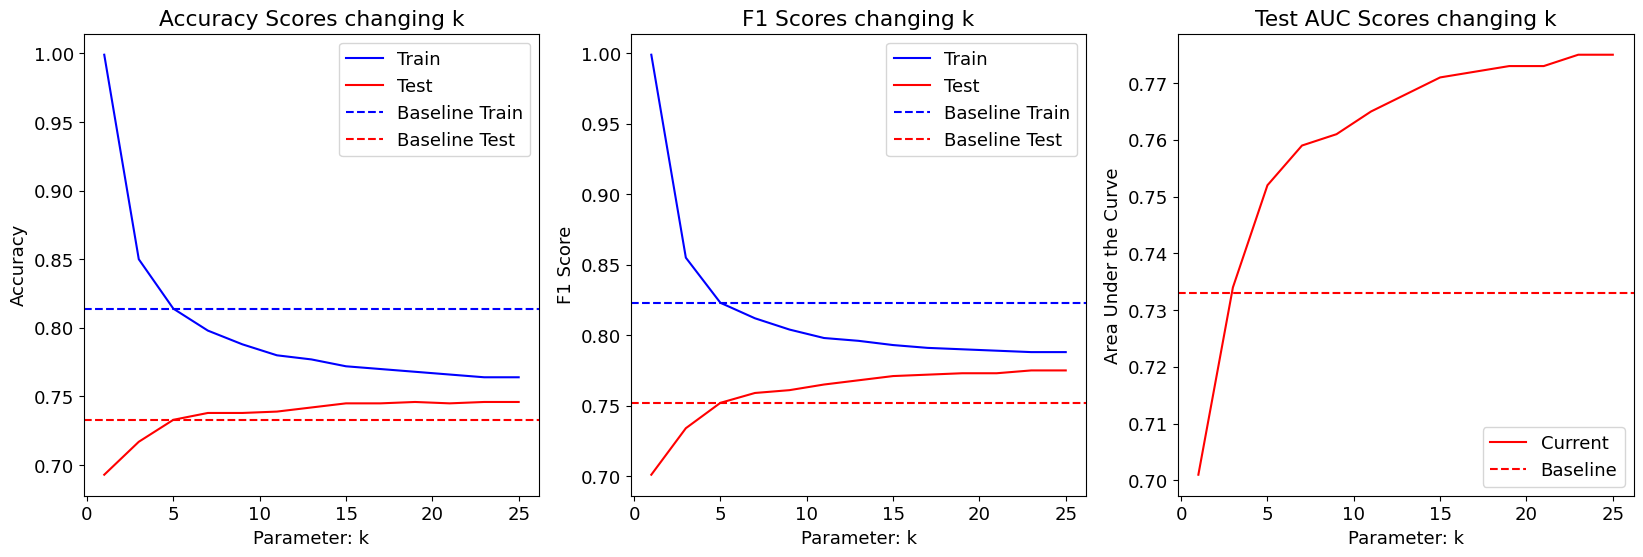

In [16]:
fig, ax = plt.subplots(1,3, figsize = (20,6))

stats = [acc_train_scores, acc_test_scores, f1_train_scores, f1_test_scores, auc_scores]

pfm.perform_visualisation(K, stats, ax, "k")

ax[0].axhline(y = df_baseline_acc.loc[2,"Accuracy"], color = "b", ls = "--")
ax[0].axhline(y = df_baseline_acc.loc[3,"Accuracy"], color = "r", ls = "--")
ax[0].legend(["Train", "Test", "Baseline Train", "Baseline Test"], loc = "upper right")

ax[1].axhline(y = df_baseline_f1.loc[2,"F1 Score"], color = "b", ls = "--")
ax[1].axhline(y = df_baseline_f1.loc[3,"F1 Score"], color = "r", ls = "--")
ax[1].legend(["Train", "Test", "Baseline Train", "Baseline Test"], loc = "upper right")

ax[2].axhline(y = float(df_baseline_auc["KNN"]), color = "r", ls = "--")
ax[2].legend(["Current", "Baseline"], loc = "lower right")

In [17]:
#Final KNN model
final_KNN = KNeighborsClassifier(n_neighbors = 25)
knn_stats, knn_roc = simulate(final_KNN, scaled_df_train, scaled_df_test, y_train, y_test, roc = True)



Final Model Selection

In [18]:
algs = [("Logistic\nRegression", log_stats), ("KNN", knn_stats)]
acc = []
f1 = []
aucs = []
for name, stat in algs:
    acc.append([name, stat[0], "Final Train"])
    acc.append([name, stat[1], "Final Test"])
    
    f1.append([name, stat[2], "Final Train"])
    f1.append([name, stat[3], "Final Test"])
    
    aucs.append([name, stat[4], "Final"])

# final results
df_acc = pd.DataFrame(acc, columns = ["Algorithm", "Accuracy", "Type"])
df_f1 = pd.DataFrame(f1, columns = ["Algorithm", "F1 Score", "Type"])
df_auc = pd.DataFrame(aucs, columns = ["Algorithm", "AUC", "Type"])

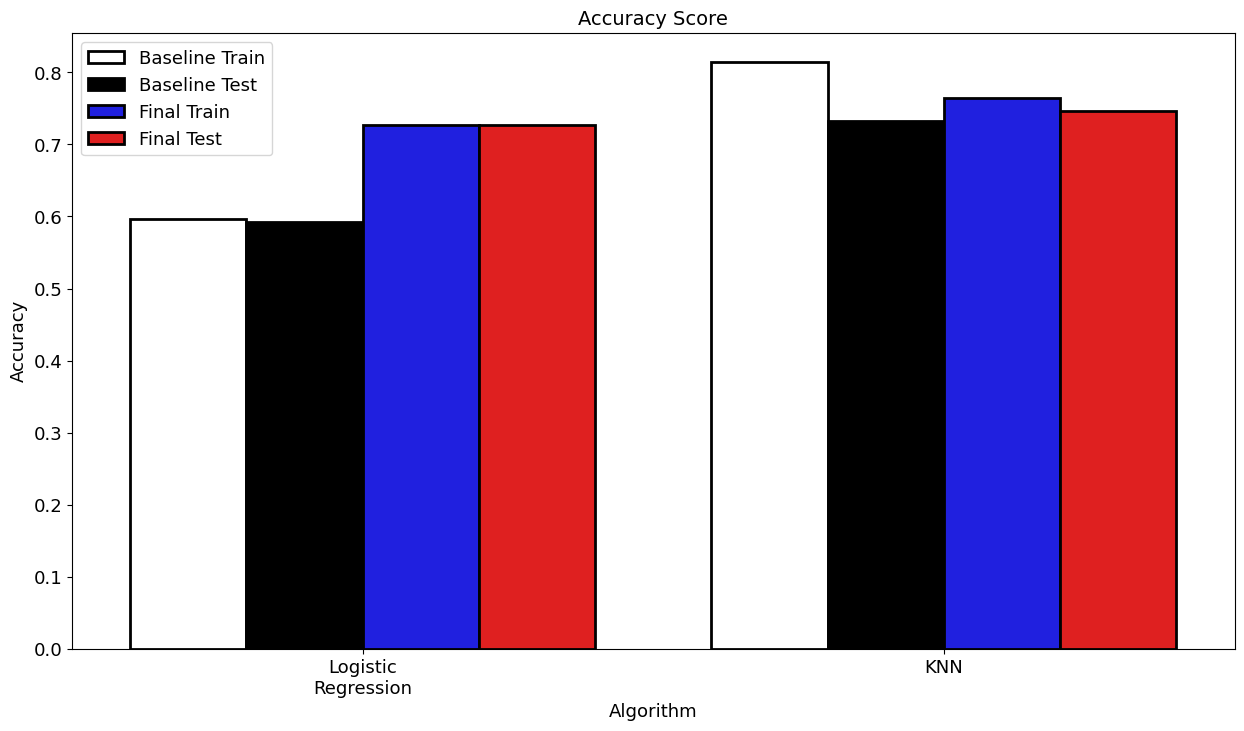

In [19]:
df_acc = pd.concat([df_baseline_acc, df_acc], axis = 0)

plt.figure(figsize = (15, 8))

sns.barplot(x = "Algorithm", y = "Accuracy", hue = "Type", 
            data = df_acc, palette = ["w", "black", "b", "r"],
           edgecolor = "black", linewidth = 2)
plt.legend(loc = "upper left")
plt.title("Accuracy Score", fontsize = 14)
plt.savefig("./images/accuracy.png", dpi = 150, bbox_inches = "tight")

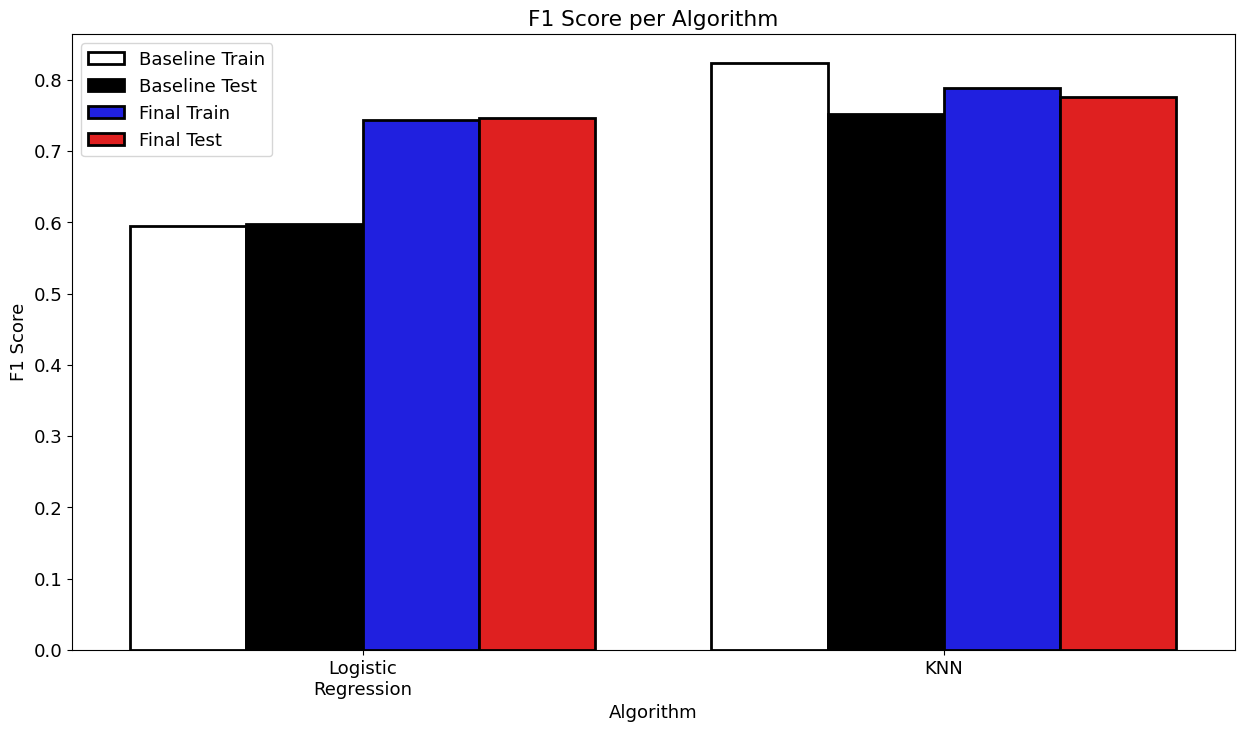

In [20]:
df_f1 = pd.concat([df_baseline_f1, df_f1], axis = 0)

plt.figure(figsize = (15, 8))

sns.barplot(x = "Algorithm", y = "F1 Score", hue = "Type", 
            data = df_f1, palette = ["w", "black", "b", "r"],
           edgecolor = "black", linewidth = 2)
plt.legend(loc = "upper left")
plt.title("F1 Score per Algorithm")
plt.savefig("./images/f1.png", dpi = 150, bbox_inches = "tight")

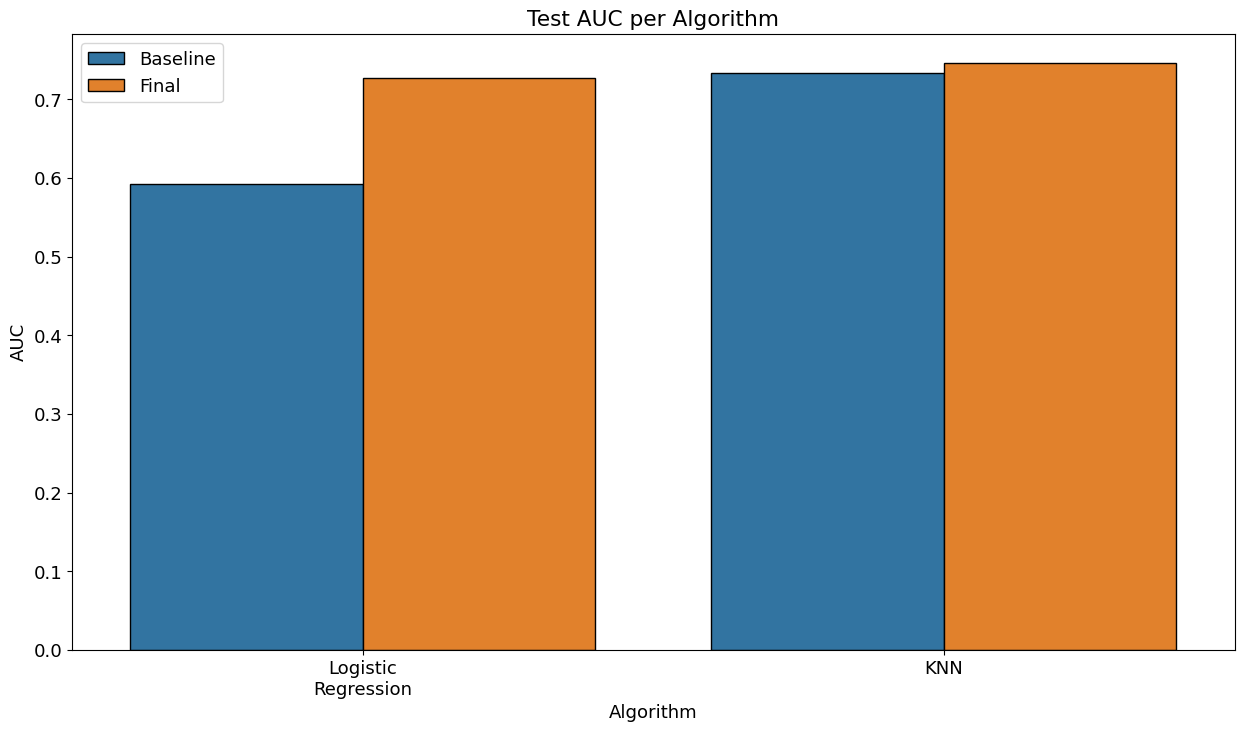

In [21]:


# creating a data frame to work with seaborn's barplot
df_baseline_auc = df_baseline_auc.T.reset_index()
df_baseline_auc.head()
df_baseline_auc.columns = ["Algorithm", "AUC"]
df_baseline_auc["Type"] = "Baseline"
df_auc = pd.concat([df_baseline_auc, df_auc], axis = 0)

plt.figure(figsize = (15, 8))

sns.barplot(x = "Algorithm", y = "AUC", hue = "Type", 
            data = df_auc, edgecolor = "black")
plt.legend(loc = "upper left")
plt.title("Test AUC per Algorithm");
plt.savefig("./images/AUC.png", dpi = 150, bbox_inches = "tight")



From above plots we can see that the performance of Logistic regression has improved a lot as compared to baseline model
The accuracy and F1 score for KNN has dropped (for train dataset) but the same parameters are increased for test dataset. 
Therefore final model that we select is KNN (modified)
We do not choose the baseline model for KNN because of the difference between the train score and test score. This difference suggests some sort of overfitting and may not perform well on unseen data where as modified KNN has better score for test data(though less score for train data).


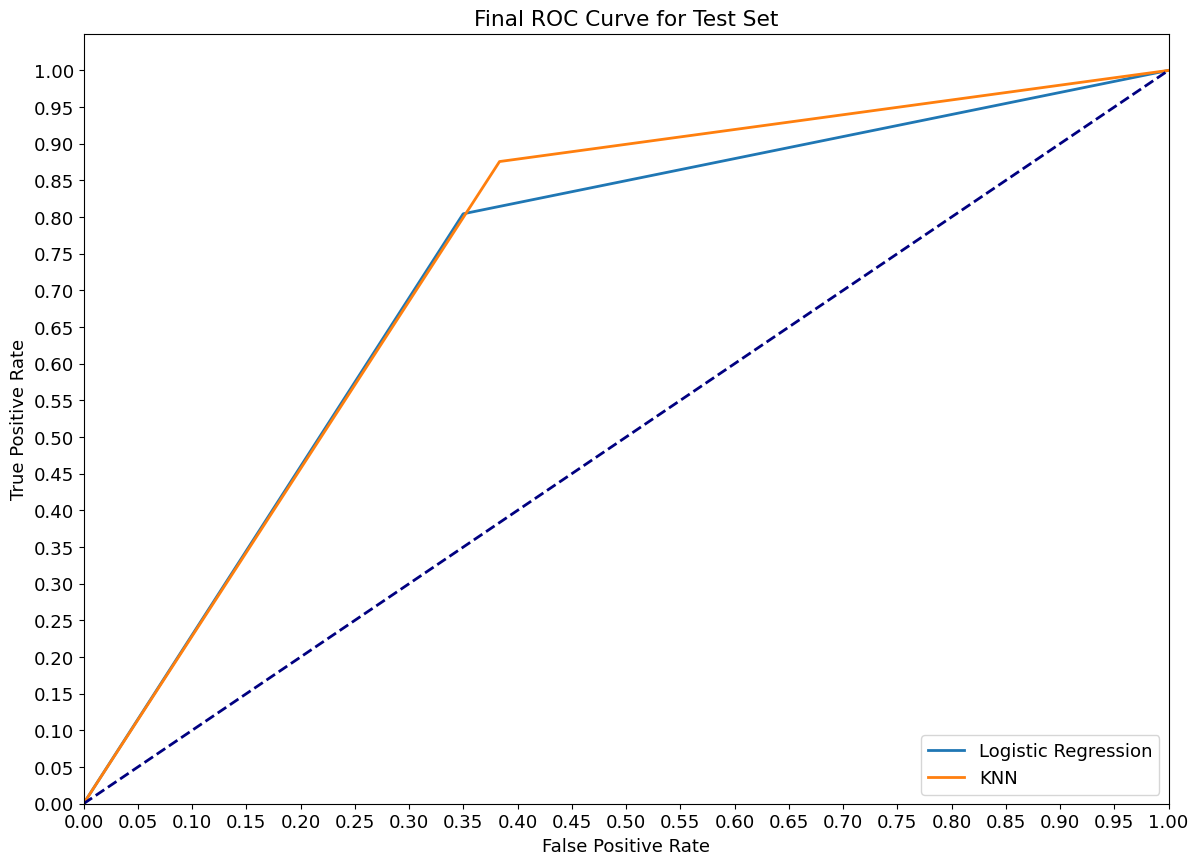

In [22]:

#Final ROC curve for test 
rocs = {"Logistic Regression": log_roc, "KNN": knn_roc}

plt.figure(figsize = (14,10))

pfm.plot_roc(rocs)

plt.title("Final ROC Curve for Test Set");
plt.savefig("./images/finalROC.png", dpi = 150, bbox_inches = "tight")

In [23]:
#Final Accuracy and F1 score print
print("Training Accuracy:", knn_stats[0])
print("Test Accuracy:", knn_stats[1])
print("--------------------")
print("Training F1 Score:", knn_stats[2])
print("Test F1 Score:", knn_stats[3])
print("--------------------")
print("Test AUC Score:", knn_stats[4])

Training Accuracy: 0.764
Test Accuracy: 0.746
--------------------
Training F1 Score: 0.788
Test F1 Score: 0.775
--------------------
Test AUC Score: 0.746
